In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF

In [3]:
preprocess = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),
                            transforms.Lambda(lambda t: t.unsqueeze(0))
                            ])

In [55]:
cnn = torchvision.models.resnet18(pretrained=True)

In [56]:
class Hook:
    
    def __init__(self, name, layer, backward=False):
        
        self.name = name
        
        if backward:
            #print('backward pass')
            layer.register_backward_hook(self.hook_fn)
        else:
            layer.register_forward_hook(self.hook_fn)
            
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        self.module = module
        #print('hook executed')

In [57]:
hooks = []
conv = [None, None]
def recursive_hook(module, hooks, depth):
    for name, layer in module.named_children():
        #print('\t'*depth,f'Going in {name}')
        #print('\t'*depth,name)
        if name == 'layer4':
            hooks.append(Hook(name, layer))
            hooks.append(Hook(name, layer, True))
            #print('\t'*depth, f'{name} layer hooked')
        recursive_hook(layer, hooks, depth+1)

def last_conv(module, conv, depth):
    for name, layer in module.named_children():
        if isinstance(layer, nn.Conv2d):
            conv[0] = name
            conv[1] = layer
            #print('\t'*depth, f'{name} layer found')
        last_conv(layer, conv, depth+1)

In [58]:
last_conv(cnn, conv, 0)

In [59]:
hooks.append(Hook(conv[0], conv[1]))
hooks.append(Hook(conv[0], conv[1], True))

In [60]:
with open('../test/imagenet_classes.txt') as f:
    lines = f.readlines()
lines = map(lambda line: line[1:].replace('\n', '').split(':'), lines)
classes = {int(line[0].replace("'", '')):line[1].replace("'", '') for line in lines}

In [62]:
image = Image.open('../test/cat_dog.png').convert('RGB')
img = preprocess(image)

In [63]:
cnn.eval()
pred = cnn(img)
print(pred.argmax().item(), classes[pred.argmax().item()])

242  boxer,


In [64]:
target = torch.zeros_like(pred)
target[0, 433]=1
#target[0, 281]=1

In [65]:
target.require_grad=True
loss = torch.sum(pred*target)

In [66]:
cnn.train()
cnn.zero_grad()
loss.backward(retain_graph=True)

In [67]:
grad = hooks[1].output[0].data
print(grad.shape)
#grad = grad.squeeze(0)
#print(grad.shape)
grad = torch.mean(grad, (2,3))
print(grad.shape)
grad = grad.unsqueeze(-1).unsqueeze(-1)
print(grad.shape)

torch.Size([1, 512, 7, 7])
torch.Size([1, 512])
torch.Size([1, 512, 1, 1])


In [68]:
relu = nn.ReLU()
cam = hooks[0].output.data
print(cam.shape)
out = relu((cam * grad).sum(1, keepdim=True))
print(out.shape)
out = nn.functional.interpolate(out, scale_factor=img.shape[2] // out.shape[2], mode='bilinear', align_corners=False)
print(out.shape)
out = out.squeeze(0).squeeze(0)
print(out.shape)
#out = out.permute(1, 0)
#print(out.shape)

torch.Size([1, 512, 7, 7])
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([224, 224])


In [69]:
out -= out.min()
out /= out.max()

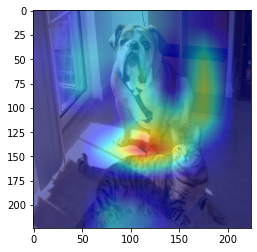

In [70]:
plt.imshow(out.numpy(), cmap='jet')
test_img = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((test_img - np.min(test_img)) / (np.max(test_img) - np.min(test_img)), alpha=0.5)

In [77]:
def plot_gradcam(model, img, idx, hooks):
    
    model.eval()
    pred = model(img)
    for index in pred.argsort(descending=True)[0,:idx]:
        print(index, classes[index.item()])
        
        target = torch.zeros_like(pred)
        target[0, index]=1
        target.require_grad=True

        loss = torch.sum(pred*target)
        print(loss)
        model.train()
        model.zero_grad()
        loss.backward(retain_graph=True)

        grad = hooks[1].output[0].data
        grad = torch.mean(grad, (2,3))
        grad = grad.unsqueeze(-1).unsqueeze(-1)

        relu = nn.ReLU()
        cam = hooks[0].output.data
        out = relu((cam * grad).sum(1, keepdim=True))
        out = nn.functional.interpolate(out, scale_factor=img.shape[2] // out.shape[2], mode='bilinear', align_corners=False)
        out = out.squeeze(0).squeeze(0)
        out -= out.min()
        out /= out.max()

        plt.imshow(out.numpy(), cmap='jet', alpha=1)
        test_img = img.squeeze(0).permute(1, 2, 0).numpy()
        plt.imshow((test_img - np.min(test_img)) / (np.max(test_img) - np.min(test_img)), alpha=0.3)
        plt.show()

tensor(207)  golden retriever,
tensor(10.4599, grad_fn=<SumBackward0>)


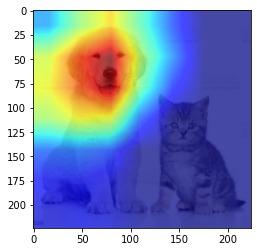

tensor(222)  kuvasz,
tensor(9.2814, grad_fn=<SumBackward0>)


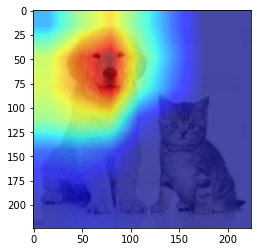

tensor(257)  Great Pyrenees,
tensor(8.2976, grad_fn=<SumBackward0>)


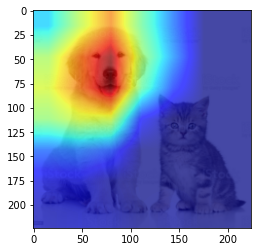

tensor(208)  Labrador retriever,
tensor(7.7080, grad_fn=<SumBackward0>)


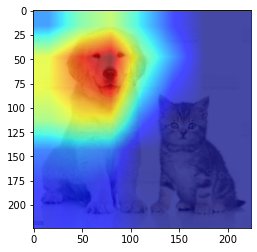

tensor(244)  Tibetan mastiff,
tensor(7.2758, grad_fn=<SumBackward0>)


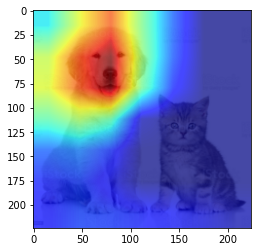

tensor(588)  hamper,
tensor(6.7806, grad_fn=<SumBackward0>)


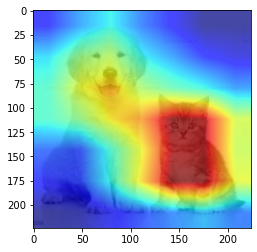

tensor(876)  tub, vat,
tensor(6.6253, grad_fn=<SumBackward0>)


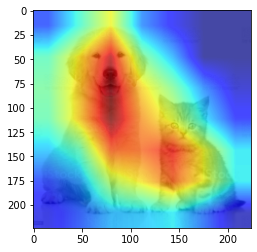

tensor(256)  Newfoundland, Newfoundland dog,
tensor(6.4431, grad_fn=<SumBackward0>)


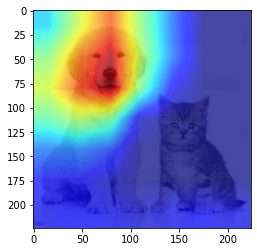

tensor(539)  doormat, welcome mat,
tensor(6.3834, grad_fn=<SumBackward0>)


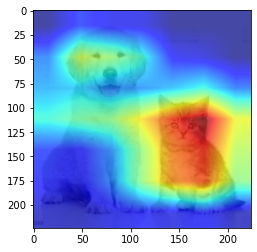

tensor(216)  clumber, clumber spaniel,
tensor(6.2789, grad_fn=<SumBackward0>)


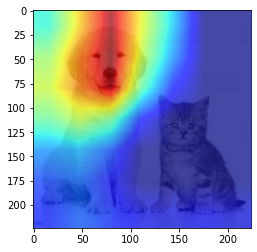

tensor(412)  ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin,
tensor(6.2071, grad_fn=<SumBackward0>)


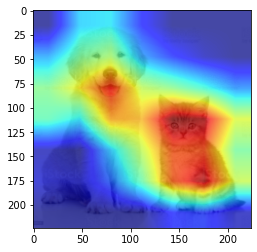

tensor(281)  tabby, tabby cat,
tensor(5.9327, grad_fn=<SumBackward0>)


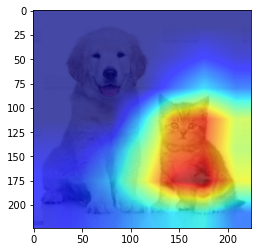

tensor(194)  Dandie Dinmont, Dandie Dinmont terrier,
tensor(5.6669, grad_fn=<SumBackward0>)


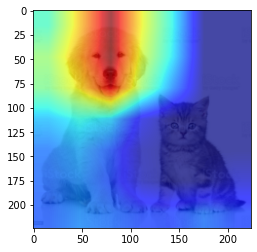

tensor(700)  paper towel,
tensor(5.6412, grad_fn=<SumBackward0>)


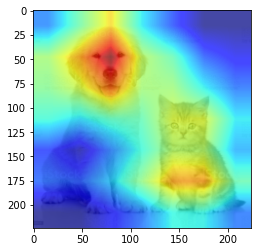

tensor(534)  dishwasher, dish washer, dishwashing machine,
tensor(5.6041, grad_fn=<SumBackward0>)


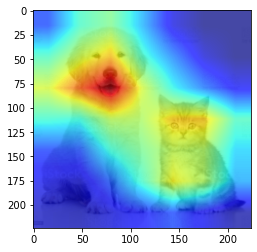

tensor(435)  bathtub, bathing tub, bath, tub,
tensor(5.5638, grad_fn=<SumBackward0>)


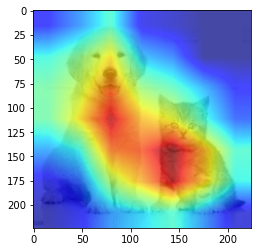

tensor(219)  cocker spaniel, English cocker spaniel, cocker,
tensor(5.3355, grad_fn=<SumBackward0>)


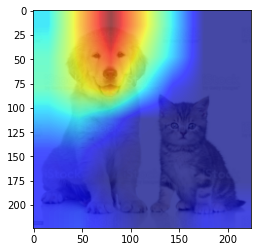

tensor(641)  maraca,
tensor(5.3327, grad_fn=<SumBackward0>)


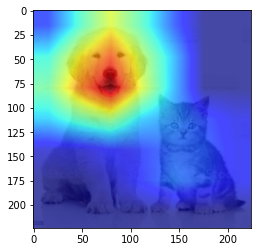

tensor(728)  plastic bag,
tensor(5.3101, grad_fn=<SumBackward0>)


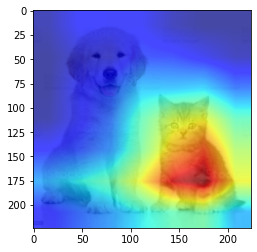

tensor(852)  tennis ball,
tensor(5.1658, grad_fn=<SumBackward0>)


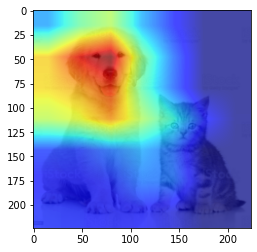

In [81]:
image = Image.open('../test/catdog.jpg').convert('RGB')
img = preprocess(image)
#for index in pred.argsort(descending=True)[0,:5]:
plot_gradcam(cnn, img, 20 ,hooks)